In [2]:
import numpy as np
import sys
import os
import importlib
sys.path.append(os.path.abspath('../'))

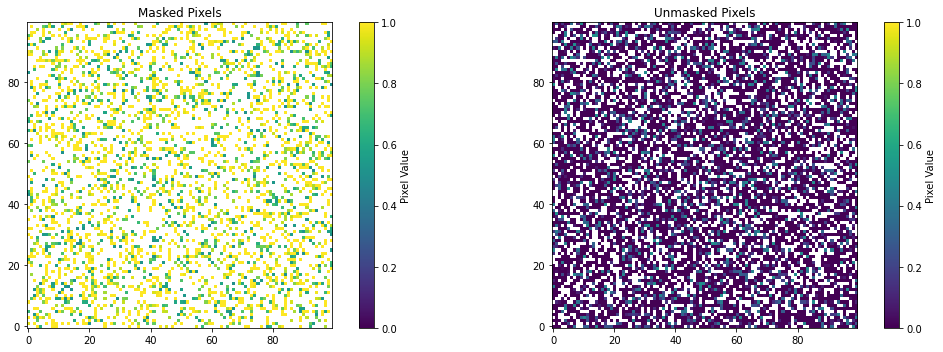

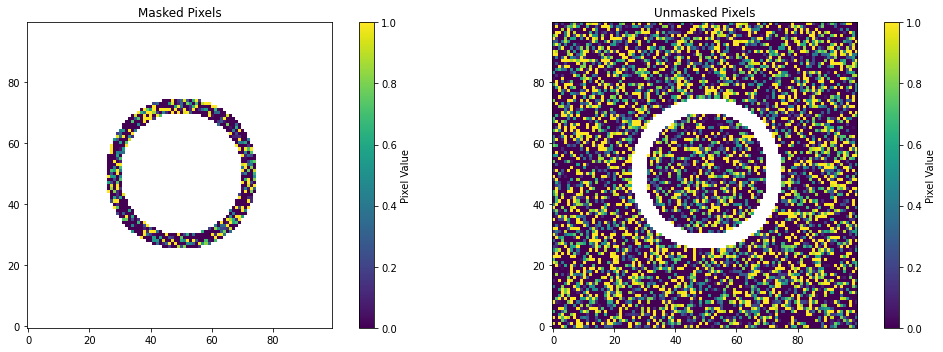

In [2]:
# importlib.reload(uvotimgpy.utils.image_operation)
from uvotimgpy.base.visualizer import MaskInspector
from uvotimgpy.utils.image_operation import UnifiedMask
from photutils.aperture import CircularAnnulus

# 使用示例
# 创建测试图像
image = np.random.normal(0, 1, (100, 100))

# 1. 从布尔数组创建并转换为ApertureMask
bool_mask = image > 0.5
unified_mask1 = UnifiedMask(bool_mask)
aperture_mask1 = unified_mask1.to_aperture_mask()

# 2. 从ApertureMask创建并转换为布尔数组
annulus = CircularAnnulus((50, 50), r_in=20, r_out=25)
aperture_mask2 = annulus.to_mask(method='center')
unified_mask2 = UnifiedMask(aperture_mask2, image_shape=image.shape)
bool_array2 = unified_mask2.to_bool_array()

# 3. 在MaskInspector中使用
inspector1 = MaskInspector(image, bool_mask)
inspector1.show_comparison(vmin=0,vmax=1)
inspector2 = MaskInspector(image, bool_array2)
inspector2.show_comparison(vmin=0,vmax=1)

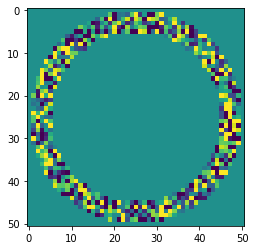

In [19]:
import matplotlib.pyplot as plt

image = np.random.normal(0, 1, (100, 100))
mask = image > 0.5
annulus = CircularAnnulus((50, 50), r_in=20, r_out=25)
annulus_mask = annulus.to_mask(method='center')
annulus_data = annulus_mask.multiply(image) # annulus_data与annulus_mask同样大小，都被裁减过
ring_mask = annulus_mask.data > 0 # ring_mask 是个被裁减过的bool array
#valid_data = annulus_data[ring_mask & ~mask[ring_mask]]
valid_data = annulus_data[ring_mask]
plt.imshow(annulus_data, vmin=-1,vmax=1)
plt.show()


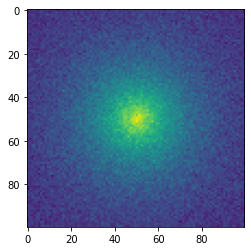

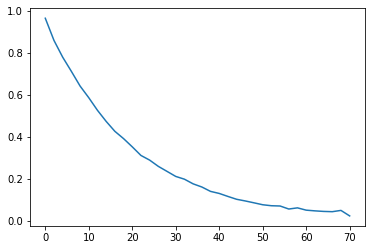

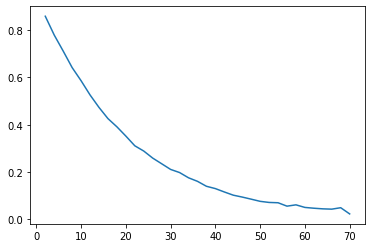

In [28]:
import astropy.units as u
import uvotimgpy.base.unit_conversion
importlib.reload(uvotimgpy.base.unit_conversion)
import uvotimgpy.utils.image_operation
importlib.reload(uvotimgpy.utils.image_operation)
from uvotimgpy.utils.image_operation import RadialProfile
import matplotlib.pyplot as plt

# 创建一个测试图像：中心亮度高，向外衰减
size = 100
center = (size//2, size//2)
y, x = np.ogrid[-size//2:size//2, -size//2:size//2]
r = np.sqrt(x*x + y*y)
image = np.exp(-r/20)  # 指数衰减

# 添加一些随机噪声
np.random.seed(42)
image += np.random.normal(0, 0.05, image.shape)

plt.imshow(image)
plt.show()

# 1. 使用普通数组
profile = RadialProfile(image, center=center, step=2, start=0, end=80)
radii, values = profile.get_radial_profile()
plt.plot(radii, values)
plt.show()
#profile.plot()

# 2. 使用带单位的数组
image_with_unit = image * u.adu

profile_with_unit = RadialProfile(image_with_unit, center=center, step=2, start=2, end=80)
#profile_with_unit.plot()
radii, values = profile_with_unit.get_radial_profile()
plt.plot(radii, values)
plt.show()

In [6]:
import uvotimgpy.utils.image_operation
importlib.reload(uvotimgpy.utils.image_operation)
from uvotimgpy.utils.image_operation import ImageDistanceCalculator
import astropy.units as u

from astropy.io import fits
from astropy.wcs import WCS
hdul = fits.open('/Users/zexixing/Research/29P/data/29p_raw_oct/05000049002/uvot/image/sw05000049002uw1_sk.img.gz')
image = hdul[1].data
wcs = WCS(hdul[1].header)
hdul.close()

#image = np.zeros((10, 12))
#coords = (3*u.pixel, 12*u.pixel)
coords = (1000*u.pixel, 1000*u.pixel)

max_dist = ImageDistanceCalculator.from_corners(image, coords, return_coords=False, distance_method='min', wcs=wcs, scale = 0.5*u.arcsec/u.pixel)
print(max_dist)

0d05m54.31138636s



真实参数:

高斯函数 1:
振幅: 1.00
中心位置 (col, row): (30.00, 40.00)
标准差: 5.00

高斯函数 2:
振幅: 0.70
中心位置 (col, row): (60.00, 70.00)
标准差: 7.00

拟合状态:
信息: The relative error between two consecutive iterates is at most 0.000000
返回码: 2
函数评估次数: 91

拟合参数:
hi

高斯分量 1:
──────────────────────────────
振幅:          1.007
中心位置: (  29.949,   39.999)
标准差:   (   4.949,    4.960)
hi

高斯分量 2:
──────────────────────────────
振幅:          0.702
中心位置: (  59.978,   70.106)
标准差:   (   7.004,    7.014)

背景:
──────────────────────────────
常数值:       -0.000


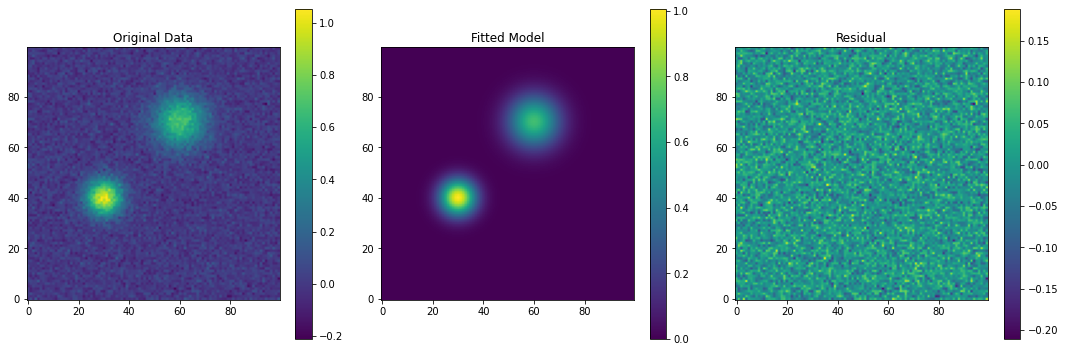

In [4]:
import numpy as np
import sys
import os
import importlib
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
from uvotimgpy.utils.math import GaussianFitter2D

def create_test_image(size=(100, 100), noise_level=0.1):
    """创建测试图像"""
    x = np.linspace(0, size[1]-1, size[1])
    y = np.linspace(0, size[0]-1, size[0])
    x, y = np.meshgrid(x, y)
    
    # 定义两个高斯峰
    true_params = [
        (1.0, 30, 40, 5.0),  # (振幅, x中心, y中心, sigma)
        (0.7, 60, 70, 7.0)
    ]
    
    image = np.zeros(size)
    for amp, x0, y0, sigma in true_params:
        g = amp * np.exp(-((x-x0)**2 + (y-y0)**2)/(2*sigma**2))
        image += g
    
    # 添加噪声
    noise = np.random.normal(0, noise_level, size)
    image += noise
    
    return image, true_params

def main():
    # 创建测试图像
    image, true_params = create_test_image(noise_level=0.05)
    
    # 创建拟合器
    gaussian_fitter = GaussianFitter2D()
    
    # 执行拟合
    fitted_model, fitter = gaussian_fitter.fit(
        image,
        n_gaussians=2,
        threshold=0.1,
        position_list=[(30, 40), (60, 70)],
        amplitude_list=[1.0, 0.7],
        sigma_list=[5.0, 7.0],
    )
    # 打印结果
    print("\n真实参数:")
    for i, (amp, x, y, sigma) in enumerate(true_params, 1):
        print(f"\n高斯函数 {i}:")
        print(f"振幅: {amp:.2f}")
        print(f"中心位置 (col, row): ({x:.2f}, {y:.2f})")
        print(f"标准差: {sigma:.2f}")
    
    gaussian_fitter.print_results(fitted_model, fitter)
    
    # 可视化结果
    fig = gaussian_fitter.plot_results(image, fitted_model)
    plt.show()

if __name__ == "__main__":
    main()


拟合状态:
信息: The relative error between two consecutive iterates is at most 0.000000
返回码: 2
函数评估次数: 62

拟合参数:

高斯分量 1:
──────────────────────────────
振幅:         58.282
中心位置: (  19.467,   10.716)
标准差:   (   0.956,    1.049)

背景:
──────────────────────────────
常数值:        0.249


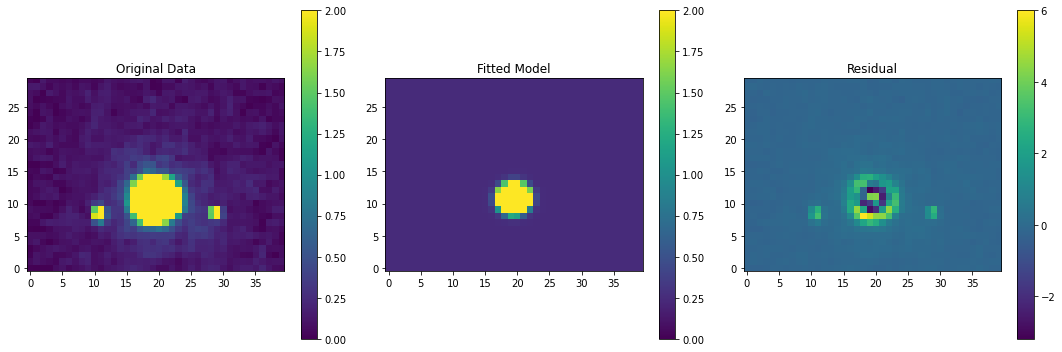

In [3]:
import numpy as np
import sys
import os
import importlib
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
from uvotimgpy.utils.math import GaussianFitter2D

from astropy.io import fits
hdulpath = '/Volumes/ZexiWork/data/HST/29P/2021/26.fits'
hdul = fits.open(hdulpath)
image = hdul[1].data
image_crop = image[1677:1707,2042:2082]

def main():
    
    # 创建拟合器
    gaussian_fitter = GaussianFitter2D()
    
    # 执行拟合
    fitted_model, fitter = gaussian_fitter.fit(
        image_crop,
        n_gaussians=1,
        threshold=10,
    )
    
    # 打印结果
    gaussian_fitter.print_results(fitted_model, fitter)
    
    # 可视化结果
    fig = gaussian_fitter.plot_results(image_crop, fitted_model)
    plt.show()

if __name__ == "__main__":
    main()

In [6]:
from uvotimgpy.base.math_tools import ErrorPropagation
import numpy as np

# 1. 测试乘法
def test_multiply():
    # 创建2x2测试数组
    values1 = np.array([[1.0, 2.0],
                       [3.0, 4.0]])
    errors1 = np.array([[0.1, 0.1],
                       [0.1, 0.1]])
    values2 = np.array([[2.0, 2.0],
                       [2.0, 2.0]])
    errors2 = np.array([[0.2, 0.2],
                       [0.2, 0.2]])
    
    # 方法1：使用 multiply 函数
    result_val1, result_err1 = ErrorPropagation.multiply(
        (values1, errors1),
        (values2, errors2)
    )
    print("\n方法1 - multiply函数:")
    print("值:")
    print(result_val1)
    print("误差:")
    print(result_err1)
    
    # 方法2：使用 propagate 和 uncertainties
    def multiply_func(*values):
        return np.prod(values, axis=0)
    
    result_val2, result_err2 = ErrorPropagation.propagate(
        multiply_func,
        [values1, values2],
        [errors1, errors2],
        derivatives=None  # 使用 uncertainties 包
    )
    print("\n方法2 - propagate函数:")
    print("值:")
    print(result_val2)
    print("误差:")
    print(result_err2)
    
    # 打印每个位置的详细计算
    print("\n详细结果:")
    for i in range(2):
        for j in range(2):
            print(f"位置[{i},{j}]:")
            print(f"{values1[i,j]}±{errors1[i,j]} × {values2[i,j]}±{errors2[i,j]} = ", end="")
            print(f"{result_val1[i,j]:.2f}±{result_err1[i,j]:.2f} (方法1)")
            print(f"{' '*len(str(values1[i,j]))}  ×  {' '*len(str(values2[i,j]))}    = ", end="")
            print(f"{result_val2[i,j]:.2f}±{result_err2[i,j]:.2f} (方法2)")

def test_divide():
    """测试除法误差传播"""
    # 创建2x2测试数组
    values1 = np.array([[10.0, 20.0],
                       [30.0, 40.0]])
    errors1 = np.array([[1.0, 1.0],
                       [1.0, 1.0]])
    values2 = np.array([[2.0, 2.0],
                       [2.0, 2.0]])
    errors2 = np.array([[0.2, 0.2],
                       [0.2, 0.2]])
    
    # 方法1：使用 divide 函数
    result_val1, result_err1 = ErrorPropagation.divide(
        (values1, errors1),
        (values2, errors2)
    )
    print("\n方法1 - divide函数:")
    print("值:")
    print(result_val1)
    print("误差:")
    print(result_err1)
    
    # 方法2：使用 propagate 和 uncertainties
    def divide_func(*values):
        return values[0] / values[1]
    
    result_val2, result_err2 = ErrorPropagation.propagate(
        divide_func,
        [values1, values2],
        [errors1, errors2],
        derivatives=None  # 使用 uncertainties 包
    )
    print("\n方法2 - propagate函数:")
    print("值:")
    print(result_val2)
    print("误差:")
    print(result_err2)
    
    # 打印每个位置的详细计算
    print("\n详细结果:")
    for i in range(2):
        for j in range(2):
            print(f"位置[{i},{j}]:")
            print(f"{values1[i,j]}±{errors1[i,j]} ÷ {values2[i,j]}±{errors2[i,j]} = ", end="")
            print(f"{result_val1[i,j]:.2f}±{result_err1[i,j]:.2f} (方法1)")
            print(f"{' '*len(str(values1[i,j]))}  ÷  {' '*len(str(values2[i,j]))}    = ", end="")
            print(f"{result_val2[i,j]:.2f}±{result_err2[i,j]:.2f} (方法2)")

def test_add_subtract():
    """测试加法和减法误差传播"""
    # 创建2x2测试数组
    values1 = np.array([[10.0, 20.0],
                       [30.0, 40.0]])
    errors1 = np.array([[10.0, 20.0],
                       [30.0, 40.0]])
    values2 = np.array([[5.0, 10.0],
                       [15.0, 20.0]])
    errors2 = np.array([[5.0, 10.0],
                       [15.0, 20.0]])
    
    print("\n=== 测试加法 ===")
    # 方法1：使用 add 函数
    add_val1, add_err1 = ErrorPropagation.add(
        (values1, errors1),
        (values2, errors2)
    )
    print("\n方法1 - add函数:")
    print("值:")
    print(add_val1)
    print("误差:")
    print(add_err1)
    
    # 方法2：使用 propagate
    def add_func(*values):
        return values[0] + values[1]
    
    add_val2, add_err2 = ErrorPropagation.propagate(
        add_func,
        [values1, values2],
        [errors1, errors2],
        derivatives=None
    )
    print("\n方法2 - propagate函数:")
    print("值:")
    print(add_val2)
    print("误差:")
    print(add_err2)
    
    print("\n=== 测试减法 ===")
    # 方法1：使用 subtract 函数
    sub_val1, sub_err1 = ErrorPropagation.subtract(
        (values1, errors1),
        (values2, errors2)
    )
    print("\n方法1 - subtract函数:")
    print("值:")
    print(sub_val1)
    print("误差:")
    print(sub_err1)
    
    # 方法2：使用 propagate
    def subtract_func(*values):
        return values[0] - values[1]
    
    sub_val2, sub_err2 = ErrorPropagation.propagate(
        subtract_func,
        [values1, values2],
        [errors1, errors2],
        derivatives=None
    )
    print("\n方法2 - propagate函数:")
    print("值:")
    print(sub_val2)
    print("误差:")
    print(sub_err2)
    

def test_custom_func():
    """测试自定义函数 f(x,y) = x*y + x 的误差传播"""
    print("\n=== 测试自定义函数: f(x,y) = x*y + x ===")
    
    # 定义函数和其导数
    #def custom_func(*values):
    #    x, y = values
    #    return x * y + x
    #    
    #def custom_derivatives(*values):
    #    x, y = values
    #    return [y + 1,  # ∂f/∂x = y + 1
    #           x]      # ∂f/∂y = x
    
    def custom_func(x, y):
        return x * y + x
    
    def custom_derivatives(x, y):
        return [y + 1,  # ∂f/∂x = y + 1
               x]      # ∂f/∂y = x
    
    # 测试1：数组输入
    print("\n--- 测试数组输入 ---")
    x1 = np.array([[1.0, 2.0],
                   [3.0, 4.0]])
    y1 = np.array([[2.0, 2.0],
                   [2.0, 2.0]])
    dx1 = np.array([[0.1, 0.1],
                    [0.1, 0.1]])
    dy1 = np.array([[0.2, 0.2],
                    [0.2, 0.2]])
    
    # 使用 uncertainties 包
    print("\n使用 uncertainties 包:")
    result_val1, result_err1 = ErrorPropagation.propagate(
        custom_func,
        (x1, dx1),
        (y1, dy1)
    )
    print("值:")
    print(result_val1)
    print("误差:")
    print(result_err1)
    
    # 使用自定义导数
    print("\n使用自定义导数:")
    result_val2, result_err2 = ErrorPropagation.propagate(
        custom_func,
        (x1, dx1),
        (y1, dy1),
        derivatives=custom_derivatives
    )
    print("值:")
    print(result_val2)
    print("误差:")
    print(result_err2)
    
    # 测试2：标量输入
    print("\n--- 测试标量输入 ---")
    x2 = 2.0
    y2 = 3.0
    dx2 = 0.2
    dy2 = 0.3
    
    # 使用 uncertainties 包
    print("\n使用 uncertainties 包:")
    result_val3, result_err3 = ErrorPropagation.propagate(
        custom_func,
        (x2, dx2),
        (y2, dy2)
    )
    print(f"值: {result_val3}")
    print(f"误差: {result_err3}")
    
    # 使用自定义导数
    print("\n使用自定义导数:")
    result_val4, result_err4 = ErrorPropagation.propagate(
        custom_func,
        (x2, dx2),
        (y2, dy2),
        derivatives=custom_derivatives
    )
    print(f"值: {result_val4}")
    print(f"误差: {result_err4}")
    
    # 打印详细比较
    print("\n详细比较:")
    print("数组输入:")
    for i in range(2):
        for j in range(2):
            print(f"\n位置[{i},{j}]:")
            print(f"uncertainties包: {result_val1[i,j]:.2f}±{result_err1[i,j]:.2f}")
            print(f"自定义导数:     {result_val2[i,j]:.2f}±{result_err2[i,j]:.2f}")
    
    print("\n标量输入:")
    print(f"uncertainties包: {result_val3:.2f}±{result_err3:.2f}")
    print(f"自定义导数:     {result_val4:.2f}±{result_err4:.2f}")

if __name__ == '__main__':
    test_multiply()
    test_divide()
    test_add_subtract()
    test_custom_func()


方法1 - multiply函数:
值:
[[2. 4.]
 [6. 8.]]
误差:
[[0.28284271 0.4472136 ]
 [0.63245553 0.82462113]]

方法2 - propagate函数:
值:
[[0.1 0.2]
 [0.3 0.4]]
误差:
[[0.28284271 0.4472136 ]
 [0.63245553 0.82462113]]

详细结果:
位置[0,0]:
1.0±0.1 × 2.0±0.2 = 2.00±0.28 (方法1)
     ×         = 0.10±0.28 (方法2)
位置[0,1]:
2.0±0.1 × 2.0±0.2 = 4.00±0.45 (方法1)
     ×         = 0.20±0.45 (方法2)
位置[1,0]:
3.0±0.1 × 2.0±0.2 = 6.00±0.63 (方法1)
     ×         = 0.30±0.63 (方法2)
位置[1,1]:
4.0±0.1 × 2.0±0.2 = 8.00±0.82 (方法1)
     ×         = 0.40±0.82 (方法2)

方法1 - divide函数:
值:
[[ 5. 10.]
 [15. 20.]]
误差:
[[0.70710678 1.11803399]
 [1.58113883 2.06155281]]

方法2 - propagate函数:
值:
[[10. 20.]
 [30. 40.]]
误差:
[[2.82842712 4.47213595]
 [6.32455532 8.24621125]]

详细结果:
位置[0,0]:
10.0±1.0 ÷ 2.0±0.2 = 5.00±0.71 (方法1)
      ÷         = 10.00±2.83 (方法2)
位置[0,1]:
20.0±1.0 ÷ 2.0±0.2 = 10.00±1.12 (方法1)
      ÷         = 20.00±4.47 (方法2)
位置[1,0]:
30.0±1.0 ÷ 2.0±0.2 = 15.00±1.58 (方法1)
      ÷         = 30.00±6.32 (方法2)
位置[1,1]:
40.0±1.0 ÷ 2.0±0.2 = 20.